<a href="https://colab.research.google.com/github/mariatomy9/machine_learning-projects/blob/master/Disaster_tweets_classification_using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')

from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout
from tensorflow.keras.optimizers import Adam

## Download Dataset

In [3]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.shape

(7613, 5)

In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## EDA
### Target Class Distribution

In [6]:
plt.rcParams['figure.figsize']=[8,4]
plt.rcParams['figure.dpi']=80

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or not real disaster tweet')

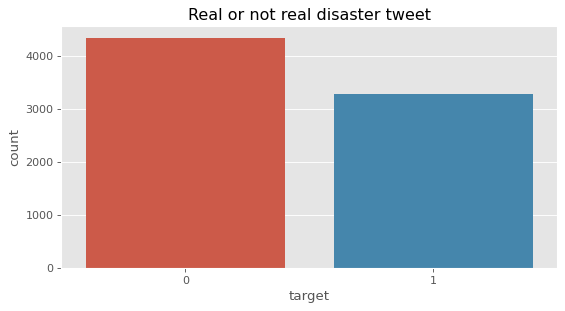

In [7]:
sns.countplot('target',data=tweet)
plt.title('Real or not real disaster tweet')

In [8]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

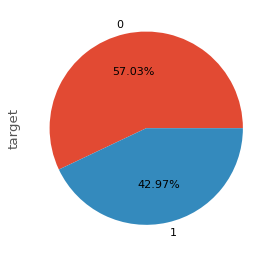

In [9]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

## Number of characters distribution in tweet

In [10]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-wftt4mb3
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-wftt4mb3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=07dc720206eb53f6caace93b29cb5d637f22641970706b0ae11c6817d8091e0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-m32m0v3v/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [11]:
import preprocess_kgptalkie as kgp

In [12]:
kgp.get_basic_features(tweet)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


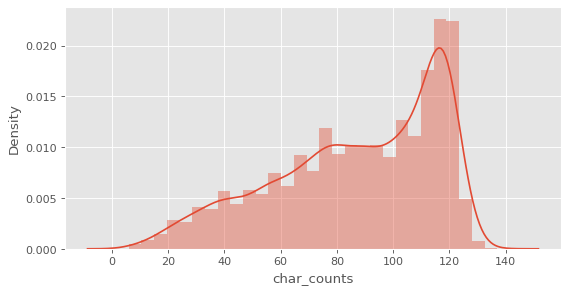

In [13]:
sns.distplot(tweet['char_counts'])

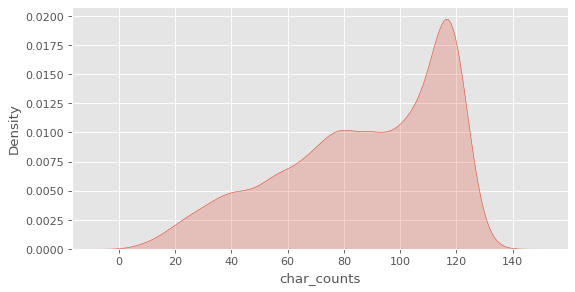

In [14]:
sns.kdeplot(tweet['char_counts'],shade=True)

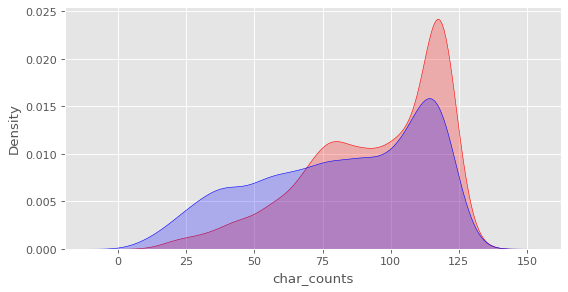

In [15]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'],shade=True,color='blue')

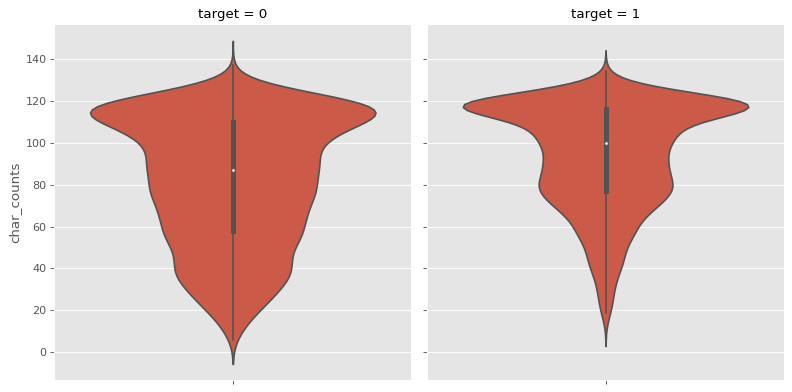

In [16]:
sns.catplot(y='char_counts',data=tweet,kind='violin',col='target')

## Number of words,average word length and stop word distribution in tweet


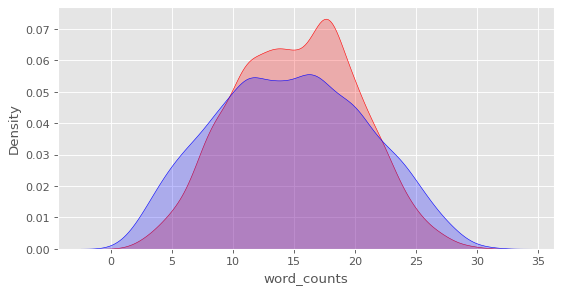

In [17]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'],shade=True,color='blue')

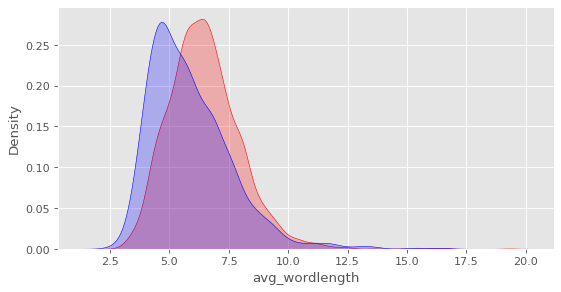

In [18]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'],shade=True,color='blue')

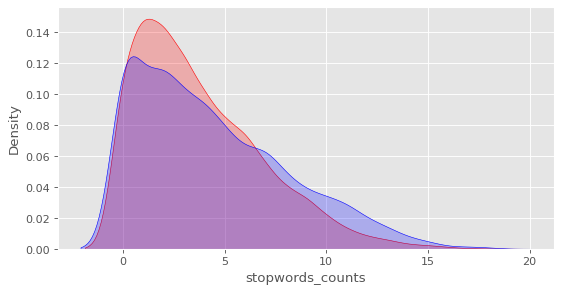

In [19]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'],shade=True,color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'],shade=True,color='blue')

## Most and common words

In [20]:
freq=kgp.get_word_freqs(tweet,'text')

In [21]:
top20=freq[:20]

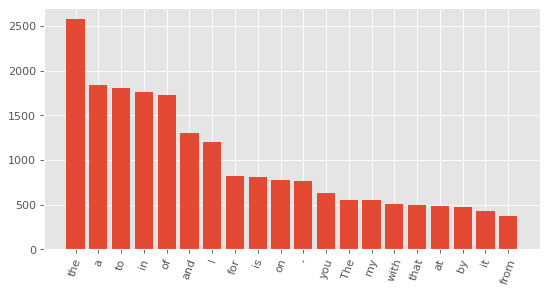

In [22]:
plt.bar(top20.index,top20.values)
plt.xticks(rotation=70)
plt.show()

In [23]:
bigram = kgp.get_ngram(tweet,'text',ngram_range=2)

In [24]:
bigram

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476),
 ('ûó bulletproof', 68475),
 ('ûó britain', 68474),
 ('ûó bbc', 68473),
 ('ûó and', 68472),
 ('ûó an', 68471),
 ('ûòåêcnbc http', 68470),
 ('ûòthe united', 68469),
 ('ûò800000 fatalities', 68468),
 ('ûò ûïdetonate', 68467),
 ('ûò your', 68466),
 ('ûò vladimir', 68465),
 ('ûò video', 68464),
 ('ûò usa', 68463),
 ('ûò two', 68462),
 ('ûò those', 68461),
 ('ûò the', 68460),
 ('ûò steve', 68459),
 ('ûò skyåênews', 68458),
 ('ûò residents', 68457),
 ('ûò part', 68456),
 ('ûò news', 68455),
 ('ûò musicians', 68454),
 ('ûò mo

## One-shot data cleaning

In [25]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [26]:
tweet['text']=tweet['text'].apply(lambda x:get_clean(x))
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0


## Disaster word classification using word cloud

In [27]:
real=kgp.get_word_freqs(tweet[tweet['target']==1],'text')
real=' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via disaster an were be people california suicide has no police who but when been killed like do 2 will just hiroshima than so out fires storm crash families we train now about into emergency s your buildings bomb there all what two mh370 attack am nuclear they wildfire video accident get new one bombing how prime minister northern burning legionnaires dead me bomber homes some if car war still atomic obama he fatal years off may us collapse forest retweet city watch debris malaysia first today 1 japan or man latest mass severe near water had earthquake before those confirmed found oil would down 70 spill floods army world home under warning 4 could injured wreckage weather derailment outbreak 3 evacuation being saudi thunderstorm migrants 40 our old flood missing flooding can during say investigators their time bridge back mosque death suspect state her cha

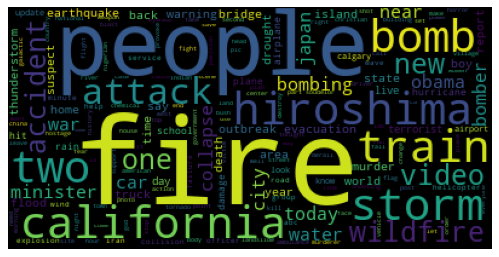

In [28]:
word_cloud=WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

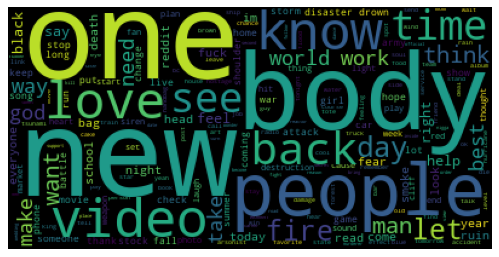

In [29]:
#not real
nreal=kgp.get_word_freqs(tweet[tweet['target']==0],'text')
nreal=' '.join(nreal.index)
word_cloud=WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification using TF-IDF and SVM

In [30]:
text=tweet['text']
y=tweet['target']

In [31]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [32]:
X.shape

(7613, 22546)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [34]:
def run_svm(clf,X_train,X_test,y_train,y_test):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test,y_pred))

In [35]:
from sklearn.svm import LinearSVC

In [36]:
clf=LinearSVC()
run_svm(clf,X_train,X_test,y_train,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



## Classification using Word2Vec and SVM

In [ ]:
!python -m spacy download en_core_web_lg

In [38]:
import spacy
import en_core_web_lg

In [39]:
nlp=en_core_web_lg.load()

In [40]:
def get_vec(x):
  doc = nlp(x)
  vec=doc.vector
  return vec

In [41]:
tweet['vec']= tweet['text'].apply(lambda x: get_vec(x))

In [42]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-0.13400537, 0.25267026, 0.09032763, -0.16645..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [43]:
X=tweet['vec'].to_numpy()
X=X.reshape(-1,1)

In [44]:
X.shape

(7613, 1)

In [46]:
X=np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)

In [47]:
X.shape

(7613, 300)

In [48]:
y=tweet['target']

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [51]:
%%time
clf=LinearSVC()
run_svm(clf,X_train,X_test,y_train,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: user 3.01 s, sys: 37.4 ms, total: 3.05 s
Wall time: 3.08 s


## Word Embeddings and Classification using Deep Learning

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D


In [56]:
token=Tokenizer()
token.fit_on_texts(text)

In [57]:
vocab_size=len(token.word_index)+1
vocab_size

22582

In [58]:
encode_text = token.texts_to_sequences(text)

In [60]:
max_length=40
X = pad_sequences(encode_text,maxlen=max_length,padding='post')

In [64]:
vec_size=100

model=Sequential()
model.add(Embedding(vocab_size,vec_size,input_length=max_length))
model.add(Conv1D(32,2,activation='relu'))
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16,activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1,activation='sigmoid'))

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           2258200   
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 32)            6432      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 19, 32)            0         
                                                                 
 dense_2 (Dense)             (None, 19, 32)            1056      
                                                                 
 dropout_3 (Dropout)         (None, 19, 32)            0         
                                                      

In [ ]:

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

In [ ]:
def get_encode(x):
  x= get_clean(x)
  x = token.texts_to_sequences([x])
  x=pad_sequences(x,maxlen=max_length,padding='post')

In [ ]:
x='i am thrilled to see this'
vec=get_encode(x)

In [ ]:
np.argmax(model.predict(vec),axis=1)